In [146]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict, Sequence, Annotated, Literal
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
from langgraph.graph import add_messages
from langgraph.types import Command
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage,SystemMessage
from dotenv import load_dotenv
from logger import logging
import os

In [147]:
load_dotenv()

True

LLM AND EMBEDDINGS MODELS

In [148]:
llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_LLM_DEPLOYMENT"), 
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    )

In [149]:
embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT"), 
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
)

STATE OF THE GRAPH

In [150]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]
    email : Annotated[str, "Email address mentioned in the content"]
    job_role : Annotated[str, "Role mentioned in the content"]
    job_description : Annotated[str, "Job description mentioned in the content"]
    candidate_summary: Annotated[str, "Concise summary of candidate's relevant experience for the role"]
    final_email_content: Annotated[str, "The complete, drafted email for the recruiter"]

EXTRACTOR AGENT'S CODE

In [ ]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser

class Format(BaseModel):  # Class names should use PascalCase
    Email: str = Field(description="email provided in the user input or default to 'rahulag5282@gmail.com")
    Role: str = Field(description="Role/designation of provided in the user input or default to 'AI Engineer'")
    Job_Description: str = Field(description="Job description provided in the user input")

In [152]:
extractor_prompt = PromptTemplate(
    input_variables=["content"],
    template="""You are an expert in extracting information from text.
    Extract the email address, role, and job description from the following content:

    {content}

    Provide the extracted information in the following format:
    **Email**: <email>
    **Role**: <role>
    **Job Description**: <job_description>""",
)

exactor_llm = llm.with_structured_output(Format)

extractor_chain = extractor_prompt | exactor_llm

def extractor_agent(state: State) -> Command[Literal["rag_agent"]]:
    """An agent that extracts email, role and job description from the content provided by the user in order to send to rag agent which extracts relevant information from the resume
    """
    try:
        messages = state.get("messages", [])
        if not messages: #edge case to handle empty messages
            print("No messages found in state.")
            return "error_or_exit"
        last_message = messages[-1].content
        
        logging.info(f"Extracting information from message: {last_message}")
        
        response = extractor_chain.invoke({"content": last_message})
        
        logging.info(f"Extracted information: {response}")
        
        return Command(
            "rag_agent",
            update={
                "email": response.get("Email", ""),
                "job_role": response.get("Role", ""),
                "job_description": response.get("Job_Description", ""),
                "messages":[AIMessage(response)],
            },
        )
    except Exception as e:
        logging.error(f"Error in extractor_agent: {e}")
        return Command("error_or_exit", update={"messages": [AIMessage(f"Error extracting information: {e}")], "email": "", "job_role": "", "job_description": ""})

RAG AGENT CODE

In [153]:
from langchain_chroma import Chroma
from langchain_core.tools import tool
from pathlib import Path
from utils import get_embeddings

In [154]:
# get_embeddings(Path("artifacts/pdfs/RahulAGowda's Resume.pdf", embeddings=embeddings))

vectorstore = Chroma(
    collection_name="resume",
    embedding_function=embeddings,
    persist_directory="artifacts/embeddings/20250613_124237",
)
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 20}
)

In [155]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser

class Format(BaseModel):  # Class names should use PascalCase
    Email: str | None = Field(description="email provided in the user input")

In [156]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information from the Stock Market Performance 2024 document.
    """

    docs = retriever.invoke(query)

    if not docs:
        return "I found no relevant information in the Stock Market Performance 2024 document."
    
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")
    
    return "\n\n".join(results)


tools = [retriever_tool]

RAG_llm = llm.bind_tools(tools)

In [157]:
RAG_prompt = PromptTemplate(
    input_variables=["content"],
    template=
    """
    You are an expert career advisor and content synthesizer. Your task is to analyze the provide job role and job description and synthesize relevant information from the provided resume content to create a tailored response.
    
    Use the following job role and job description to guide your synthesis:
    **Job Role**: {job_role}
    **Job Description**: {job_description}
    
    **output format**:
    **candidate_summary**: <summary of candidate's relevant experience for the role>
    """
)

RAG_chain = RAG_prompt | RAG_llm

def rag_agent(state: State) -> Command[Literal["Mailer"]]:
    """an agent that retrieves relevant information from the resume based on the job role and job description provided by the user"""
    try:
        messages_content = state.get("messages", [])
        job_role = messages_content[0] if len(messages_content) > 0 else ""
        job_description = messages_content[1] if len(messages_content) > 1 else ""
        
        logging.info(f"Retrieving information for job role: {job_role} and job description: {job_description}")
        
        logging.info(f"Messages content: {messages_content}")
        
        if not job_role and not job_description:  # edge case to handle empty messages
            print("No messages found in state.")
            return "error_or_exit"
        response = RAG_chain.invoke({"job_role": job_role, "job_description": job_description})
        
        logging.info(f"Retrieved candidate summary: {response.content}")
        
        return Command(
            "Mailer",
            update = {
                "candidate_summary": response.content,
                "messages": [AIMessage(response)],
            },
        )
    except Exception as e:
        logging.error(f"Error in rag_agent: {e}")

MAILER AGENT CODE

In [158]:
from langchain_google_community import GmailToolkit

toolkit = GmailToolkit()

In [159]:
mail_prompt = PromptTemplate(
    input_variables=["candidate_summary", "target_role", "company_name"],
    template="""
    You're an expert email writer. Your job is to draft a professional and concise email from a job candidate to a recruiter.

    **Goal:** Highlight the candidate's suitability for the **{target_role}** at **{company_name}** using the provided summary.

    **Information to use:**
    - **Candidate Summary:** {candidate_summary} (This is the core content for the email body)
    - **Target Role:** {target_role}
    - **Company Name:** {company_name} (If not specific, use "your company" or "your team")

    **Email Guidelines:**
    - **Subject:** Clear and professional (e.g., "Application for [Target Role]").
    - **Greeting:** Polite and standard (e.g., "Dear Hiring Team,").
    - **Body:** Briefly state interest, then integrate the `candidate_summary` to show a strong match with the role. Be direct and impactful.
    - **Closing:** Professional call to action for an interview, followed by a standard closing.
    - **Signature:** Use "Candidate Name" as a placeholder.
    - **Tone:** Confident, professional, and to the point.

    **Draft the complete email. Do NOT include any extra text before or after the email.**
    """
)

llm = llm.bind_tools(tools)

mail_chain = mail_prompt | llm

def mail_agent(state: State) -> Literal["END"]:
    """an agent that composes the final professional email to recruiters."""
    "An agent that composes the final professional email to recruiters."
    
    try:
        # Retrieve all necessary information from the state
        candidate_summary = state.get("candidate_summary", "")
        candidate_email = state.get("email", "") # Using 'email' from state as candidate_email
        target_role = state.get("role", "")
        job_description = state.get("job_description", "")
        company_name = state.get("company_name", "your team") # Use a default if not found
        
        logging.info(f"Composing email with candidate summary: {candidate_summary}, target role: {target_role}, job description: {job_description}, company name: {company_name}")

        if not all([candidate_summary, candidate_email, target_role, job_description]):
            print("Missing essential information to compose email (summary, email, role, or job description).")
            return "error_node"
        final_email_content = mail_chain.invoke({
            "candidate_summary": candidate_summary,
            "candidate_email": candidate_email,
            "target_role": target_role,
            "job_description": job_description,
            "company_name": company_name
        })
        
        logging.info(f"Final email content generated: {final_email_content}")

        print(f"Generated Email Subject: (See email content for subject)")
        print(f"Generated Email Content: \n{final_email_content}")

        state["final_email_content"] = final_email_content

        return "END"
    except Exception as e:
        logging.error(f"Error in mail_agent: {e}")
        return "error_node"

In [160]:
graph = StateGraph(State)

graph.add_node("extractor_agent",extractor_agent)
graph.add_node("rag_agent",rag_agent)
graph.add_node("Mailer",mail_agent)

graph.add_edge(START, "extractor_agent")
graph.add_edge("extractor_agent", "rag_agent")
graph.add_edge("rag_agent", "Mailer")
graph.add_edge("Mailer", END)

app = graph.compile()

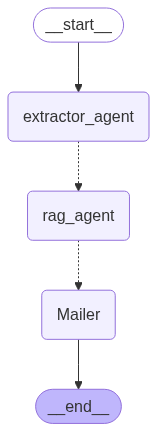

In [161]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [165]:
user_query = """🚀 We're Hiring | Industrial AI - Machine Learning Engineer
 📍 Location: Warsaw, Poland (Hybrid)
We’re looking for a Machine Learning Engineer passionate about Industrial AI to join our team in Warsaw. If you're experienced in Document AI / Intelligent Document Processing and have a strong grasp of Python, ML, OCR, and Generative AI, this could be your next challenge!
🔧 Your Key Responsibilities:
Build production-grade models for image/text-based content extraction & classification
Work directly with business teams to deliver impactful AI solutions
Design and deploy Python/ML/OCR-based components
Own full lifecycle: from dev to deployment and production support
Collaborate cross-functionally with product managers and engineering teams

📬 Interested? Let’s connect!
 Or feel free to share with someone in your network who’d be a great fit.
rahulag5282@gmail.com"""

response = app.invoke(
    {"messages": [{"role": "user", "content": user_query}]},
    stream_mode="values"  # Use stream_mode instead of stream
)

# Process the streamed response
for event in response:
    if "messages" in event and event["messages"]:
        last_message = event["messages"][-1]
        # If the message has a pretty_print method
        if hasattr(last_message, "pretty_print"):
            last_message.pretty_print()
        else:
            # Fallback to regular printing
            role = last_message.get("role", "unknown")
            content = last_message.get("content", "")
            print(f"[{role.upper()}]: {content}")

TypeError: Command.__init__() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given